In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'    
plt.rcParams['axes.unicode_minus'] = False       

In [11]:
# 데이터셋 불러오기
df = pd.read_csv(r'C:\skproject\pyproject\20250620_143916_mall_customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [12]:
# Annual Income, Spending Score 컬럼만 사용
X = df[['Annual Income (k$)', 'Spending Score (1-100)']]

# StandardScaler로 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
from sklearn.model_selection import train_test_split

# 학습데이터/테스트 데이터 8:2로 분리
X_train, X_test = train_test_split(
    X_scaled, test_size=0.2, random_state=42
)

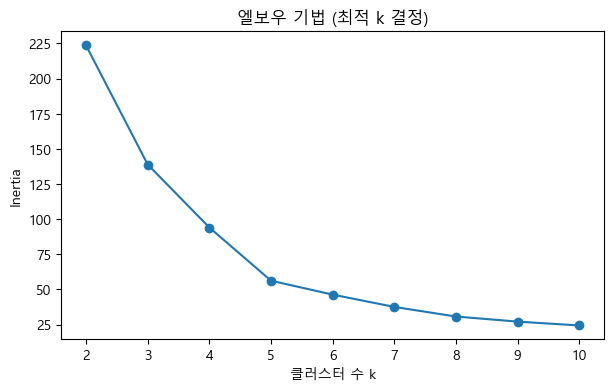

In [14]:
# 여러 k값에 대해 inertia 값 계산하여 엘보우 그래프 그리기
inertias = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train)
    inertias.append(kmeans.inertia_)
    
# inertia값이 급격히 꺾이는 '엘보우 지점'이 최적 k
plt.figure(figsize=(7,4))
plt.plot(k_range, inertias, marker='o')
plt.xlabel('클러스터 수 k')
plt.ylabel('Inertia')
plt.title('엘보우 기법 (최적 k 결정)')
plt.xticks(k_range)
plt.show()

In [15]:
# k=5 엘보우 그래프 보고 최적 k 찾았습니다(5부터 완만해지는 것 같아서)
optimal_k = 5
# 선택한 k로 KMeans 모델 학습
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans.fit(X_train)

# 학습 데이터 클러스터 할당
train_labels = kmeans.predict(X_train)
# 테스트 데이터 클러스터 할당
test_labels = kmeans.predict(X_test)

In [16]:
# Silhouette Score: 각 점이 자신의 클러스터에 얼마나 잘 속하는지 정량적으로 평가

# 학습 데이터 실루엣 점수
train_sil_score = silhouette_score(X_train, train_labels)
# 테스트 데이터 실루엣 점수
test_sil_score = silhouette_score(X_test, test_labels)

print(f'학습 데이터 Silhouette Score: {train_sil_score:.4f}')
print(f'테스트 데이터 Silhouette Score: {test_sil_score:.4f}')

학습 데이터 Silhouette Score: 0.5510
테스트 데이터 Silhouette Score: 0.5666


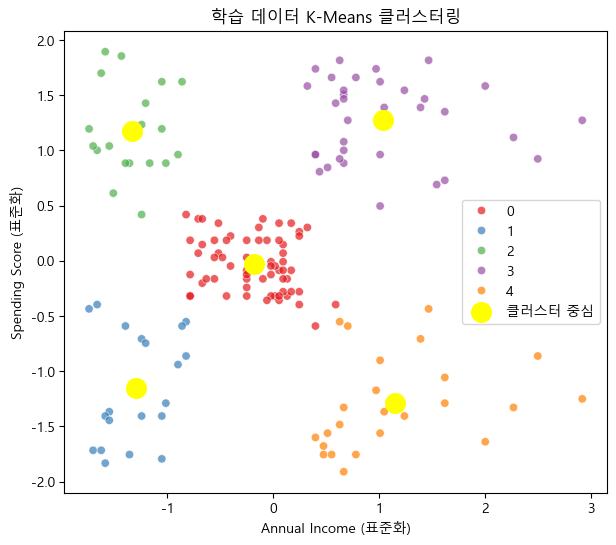

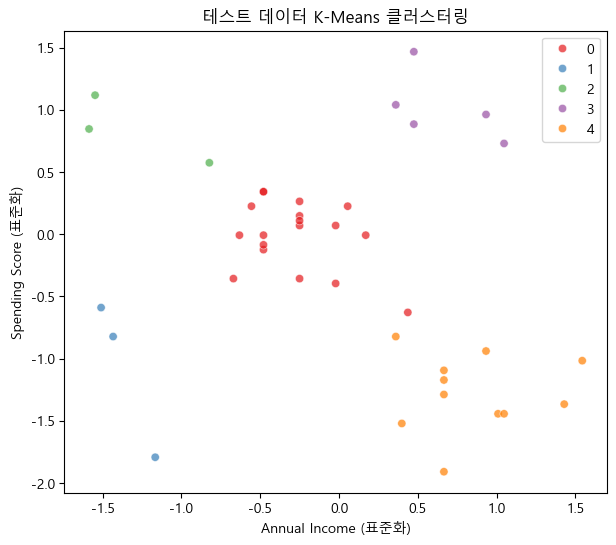

In [17]:
# 학습 데이터 산점도
plt.figure(figsize=(7,6))
sns.scatterplot(x=X_train[:,0], y=X_train[:,1], hue=train_labels, palette='Set1', alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=200, c='yellow', label='클러스터 중심')
plt.xlabel('Annual Income (표준화)')
plt.ylabel('Spending Score (표준화)')
plt.title('학습 데이터 K-Means 클러스터링')
plt.legend()
plt.show()

# 테스트 데이터 산점도
plt.figure(figsize=(7,6))
sns.scatterplot(x=X_test[:,0], y=X_test[:,1], hue=test_labels, palette='Set1', alpha=0.7)
plt.xlabel('Annual Income (표준화)')
plt.ylabel('Spending Score (표준화)')
plt.title('테스트 데이터 K-Means 클러스터링')
plt.show()

In [19]:
# 학습 데이터에 클러스터 번호 부여
train_df = pd.DataFrame(X_train, columns=['소득(표준화)', '소비점수(표준화)'])
train_df['클러스터'] = train_labels

# 클러스터별 평균 소득, 소비 점수 등 통계 확인
cluster_summary = train_df.groupby('클러스터').mean()
print('\n[클러스터별 평균 소득/소비점수]')
print(cluster_summary)

# 각 클러스터별 데이터 수 (규모)
print('\n[클러스터별 데이터 개수]')
print(train_df['클러스터'].value_counts())

# 평가 기준: 각 클러스터의 특징(고소득/고소비, 저소득/저소비 등) 주석·출력으로 명확히 분석!



[클러스터별 평균 소득/소비점수]
       소득(표준화)  소비점수(표준화)
클러스터                     
0    -0.180717  -0.031180
1    -1.298142  -1.147177
2    -1.331189   1.177315
3     1.040633   1.272205
4     1.147564  -1.288876

[클러스터별 데이터 개수]
클러스터
0    63
3    34
4    24
1    20
2    19
Name: count, dtype: int64


## 클러스터별 고객 특성 및 해석

| 클러스터 | 소득 | 소비점수 | 인원수 | 해석                                 |
|:--------:|:-----------:|:---------------:|:-----:|:-------------------------------------|
|    0     |   -0.18     |     -0.03       |  63   | 평균에 가까운 소득/소비<br>**주류 고객층(보통형)**         |
|    1     |   -1.30     |     -1.15       |  20   | 매우 낮은 소득/소비<br>**절약형/소극적 고객**            |
|    2     |   -1.33     |     +1.18       |  19   | 소득은 낮지만 소비는 높음<br>**과소비 위험군**           |
|    3     |   +1.04     |     +1.27       |  34   | 높은 소득/소비<br>**VIP, 활발한 고소득·고소비 고객**      |
|    4     |   +1.15     |     -1.29       |  24   | 높은 소득, 낮은 소비<br>**저관여 고소득(투자·절약형)**   |

---

### 분석 요약

- **클러스터 0:**  
  평균적인 소득과 소비를 보이는 주 고객군, 전체의 약 40%를 차지합니다.

- **클러스터 1:**  
  소득과 소비가 모두 낮은 그룹으로, 절약형 또는 소극적 소비자인 것 같습니다.

- **클러스터 2:**  
  소득은 낮지만 소비 성향이 강한 집단, 과소비 위험이 있으므로 타겟 마케팅이 필요한 집단입니다.

- **클러스터 3:**  
  소득과 소비가 모두 높은 VIP 고객군, 고가/프리미엄 마케팅에 적합합니다.

- **클러스터 4:**  
  소득은 높지만 소비는 낮은 저관여 고소득층, 신상품, 투자상품 등 맞춤 마케팅 전략이 필요합니다.
